# Visualizing invasive and non-invasive EEG data

[Liberty Hamilton, PhD](https://csd.utexas.edu/research/hamilton-lab)
Assistant Professor, University of Texas at Austin
Department of Speech, Language, and Hearing Sciences
and Department of Neurology, Dell Medical School 

Welcome! In this notebook we will be discussing how to look at time series electrophysiological 🧠 data that is recorded noninvasively at the scalp (scalp electroencephalography or EEG), or invasively in patients who are undergoing surgical treatment for epilepsy (sometimes called intracranial EEG or iEEG, also called stereo EEG/sEEG, or electrocorticography/ECoG). 

### Python libraries you will be using in this tutorial:
* MNE-python
* matplotlib
* numpy

![MNE-python logo](https://mne.tools/stable/_static/mne_logo.png)
MNE-python is open source python software for exploring and analyzing human neurophysiological data (EEG/MEG/iEEG).

### What you will learn to do 
* Load some sample EEG data
* Load some sample intracranial EEG data
* Plot the raw EEG data/iEEG data
* Plot the power spectrum of your data
* Epoch data according to specific task conditions (sentences)
* Plot all epochs and averaged evoked activity
* Plot average evoked activity in response to specific task conditions (ERPs)
    * Plot by channel as well as averaging across channels
* Plot EEG activity at specific time points on the scalp (topomaps)
* Customize your plots

### Other Resources:
* [MNE-python tutorials](https://mne.tools/stable/auto_tutorials/index.html) -- This has many additional resources above and beyond that also include how to preprocess your data, remove artifacts, and more!

<a id="basics1"></a>
# 1. The basics: loading in your data

In [1]:
import mne # This is the mne library
import numpy as np # This gives us the power of numpy, which is just generally useful for array manipulation
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm

datasets = {'ecog': '/home/jovyan/data/we_eeg_viz_data/ecog/sub-S0006/S0006_ecog_hg.fif',
            'eeg': '/home/jovyan/data/we_eeg_viz_data/eeg/sub-MT0002/MT0002-eeg.fif'}
event_files = {'ecog': '/home/jovyan/data/we_eeg_viz_data/ecog/sub-S0006/S0006_eve.txt',
               'eeg': '/home/jovyan/data/we_eeg_viz_data/eeg/sub-MT0002/MT0002_eve.txt'}
stim_file = '/home/jovyan/data/we_eeg_viz_data/stimulus_list.csv'

In [91]:
# Get some information about the stimuli (here, the names of the sound files that were played)
ev_names=np.genfromtxt(stim_file, skip_header=1, delimiter=',',dtype=np.str, usecols=[1],encoding='utf-8')
ev_nums=np.genfromtxt(stim_file, skip_header=1, delimiter=',',dtype=np.int, usecols=[0], encoding='utf-8')
event_id = dict()
for i, ev_name in enumerate(ev_names):
    event_id[ev_name] = ev_nums[i]

## 1.1. Choose which dataset to look at (start with EEG)

For the purposes of this tutorial, we'll be looking at some scalp EEG and intracranial EEG datasets from my lab.  Participants provided written informed consent for participation in our research. These data were collected from two distinct participants listening to sentences from the [TIMIT acoustic-phonetic corpus](https://catalog.ldc.upenn.edu/LDC93S1). This is a database of English sentences spoken by multiple talkers from throughout the United States, and has been used in speech recognition research, neuroscience research, and more!

The list of stimuli is in the `stimulus_list.csv` file. Each stimulus starts with either a "f" or a "m" to indicate a female or male talker. The rest of the alphanumeric string has to do with other characteristics of the talkers that we won't go into here. The stimulus timings have been provided for you in the event files (ending with the suffix `_eve.txt`. We'll talk about those more later. 

### EEG Data
The EEG data was recorded with a 64-channel [BrainVision ActiCHamp](https://www.brainproducts.com/productdetails.php?id=74) system. These data are part of an ongoing project in our lab and are unpublished. You can find similar (larger) datasets from [Broderick et al.](https://datadryad.org/stash/dataset/doi:10.5061/dryad.070jc), or Bradley Voytek's lab has a list of [Open Electrophysiology datasets](https://github.com/openlists/ElectrophysiologyData).

### The ECoG Data
The ECoG data was recorded from 106 electrodes across multiple regions of the brain while our participant listened to TIMIT sentences. This is a smaller subset of sentences than the EEG dataset and so is a bit faster to load. The areas we recorded from are labeled according to a clinical montage. For iEEG and ECoG datasets, these names are rarely standardized, so it can be hard to know exactly what is what without additional information. Here, each channel is named according to the general location of the electrode probe to which it belongs.

| Device | General location  |
|---|---|
| RAST   | Right anterior superior temporal  |
| RMST   | Right middle superior temporal |
| RPST   | Right posterior superior temporal |
| RPPST  | Right posterior parietal/superior temporal |
| RAIF   | Right anterior insula |
| RPI    | Right posterior insula  |
| ROF    | Right orbitofrontal  |
| RAC    | Right anterior cingulate  |

In [93]:
data_type = 'eeg' # Can choose from 'eeg' or 'ecog'

## 1.2. Load the data

This next command loads the data from our fif file of interest. The `preload=True` flag means that the data will be loaded (necessary for some operations). If `preload=False`, you can still perform some aspects of this tutorial, and this is a great option if you have a large dataset and would like to look at some of the header information and metadata before you start to analyze it.

In [94]:
raw = mne.io.read_raw_fif(datasets[data_type], preload=True) 

Opening raw data file /Users/liberty/Documents/Austin/code/neurohackademy2020/data/eeg/sub-MT0002/MT0002-eeg.fif...


<ipython-input-94-d473afb2d718>:1: RuntimeWarning: This filename (/Users/liberty/Documents/Austin/code/neurohackademy2020/data/eeg/sub-MT0002/MT0002-eeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = mne.io.read_raw_fif(datasets[data_type], preload=True)


    Range : 0 ... 604351 =      0.000 ...  4721.492 secs
Ready.
Reading 0 ... 604351  =      0.000 ...  4721.492 secs...


There is a lot of useful information in the info structure. For example, we can get the sampling frequency (`raw.info['sfreq']`), the channel names (`raw.info['ch_names']`), the channel types and locations (in `raw.info['chs']`), and whether any filtering operations have been performed already (`raw.info['highpass']` and `raw.info['lowpass']` show the cut-offs for the data).

In [95]:
print(raw.info)

<Info | 19 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, ...
    chs : list | 66 items (EEG: 64, EOG: 2)
    comps : list | 0 items
    custom_ref_applied : bool | True
    dev_head_t : Transform | 3 items
    dig : list | 64 items (64 EEG)
    events : list | 0 items
    file_id : dict | 4 items
    highpass : float | 1.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 15.0 Hz
    meas_date : tuple | 2019-07-01 20:29:09 GMT
    meas_id : dict | 4 items
    nchan : int | 66
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 128.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : 

In [96]:
sampling_freq = raw.info['sfreq'] 
nchans = raw.info['nchan']

print('The sampling frequency of our data is %d'%(sampling_freq))
print('Here is our list of %d channels: '%nchans)
print(raw.ch_names)

The sampling frequency of our data is 128
Here is our list of 66 channels: 
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8', 'hEOG', 'vEOG']


<IPython.core.display.Javascript object>


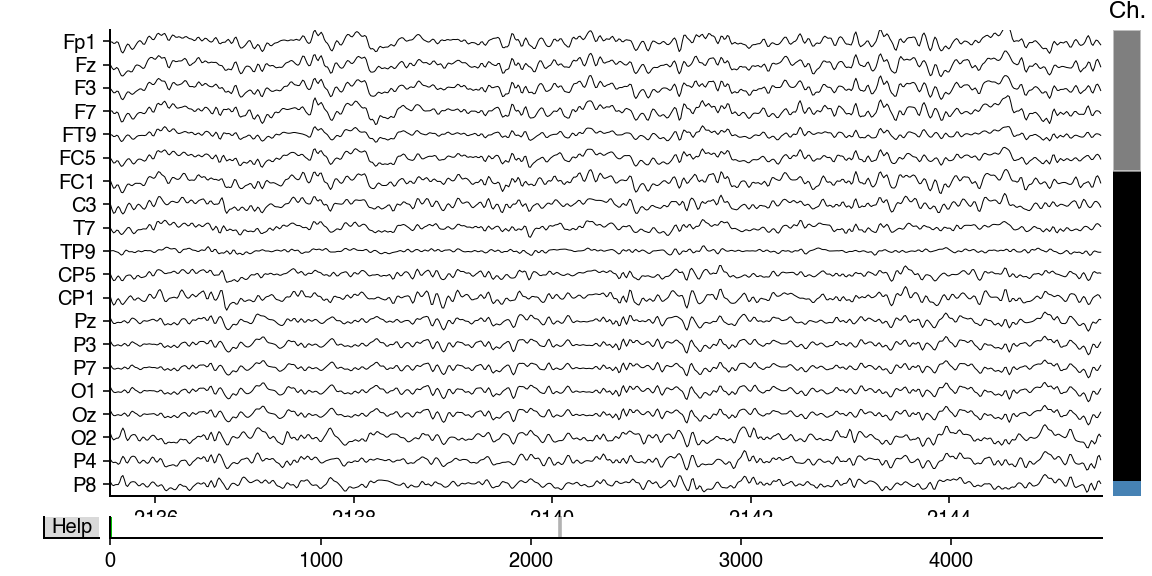

In [97]:
eeg_colors = {'eeg': 'k', 'eog': 'steelblue'}
fig = raw.plot(show=False, color=eeg_colors, scalings='auto');
fig.set_figwidth(8)
fig.set_figheight(4)


<a id="plots2"></a>
# 2. Let's make some plots!

MNE-python makes creating some plots *super easy*, which is great for data quality checking, exploration, and eventually manuscript figure generation. For example, one might wish to plot the power spectral density (PSD), which 

## 2.2. Power spectral density

<IPython.core.display.Javascript object>


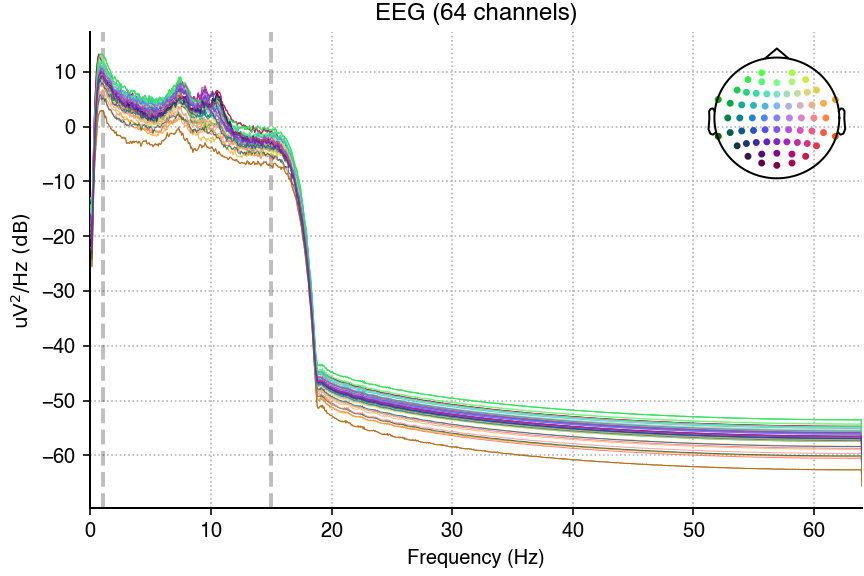

Effective window size : 16.000 (s)


In [103]:
raw.plot_psd();

## 2.3. Sensor positions (for EEG)

For EEG, MNE-python also has convenient functions for showing the location of the sensors used. Here, we have a 64-channel montage. You can also use this information to help interpret some of your plots if you're plotting a single channel or a group of channels.

For ECoG, we will not be plotting sensors in this way. If you would like read more about that process, please see [this tutorial](https://mne.tools/stable/auto_tutorials/misc/plot_ecog.html).  You can also check out [Noah Benson's session](https://neurohackademy.org/course/introduction-to-the-geometry-and-structure-of-the-human-brain/) (happening in parallel with this tutorial!) for plotting 3D brains.

<IPython.core.display.Javascript object>


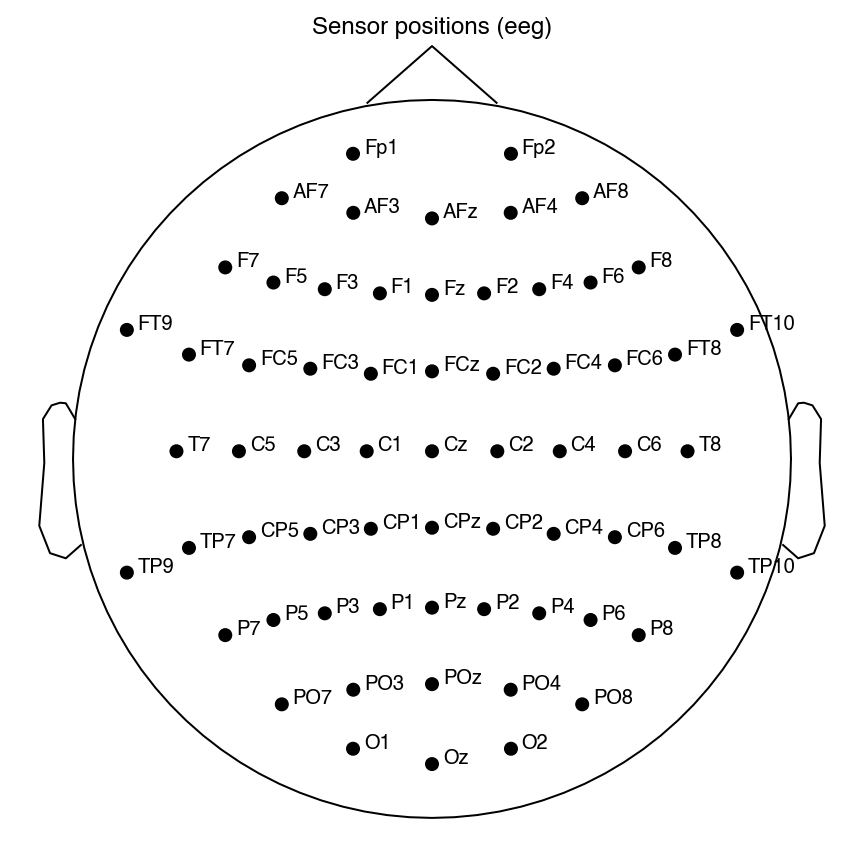

In [104]:
if data_type == 'eeg':
    raw.plot_sensors(kind='topomap',show_names=True);


Ok, awesome! So now we know where the sensors are, how densely they tile the space, and what their names are. *Knowledge = Power!*

So what if we wanted to look at the power spectral density plot we saw above by channel? We can use `plot_psd_topo` for that! There are also customizable options for playing with the colors.

Effective window size : 16.000 (s)


<IPython.core.display.Javascript object>


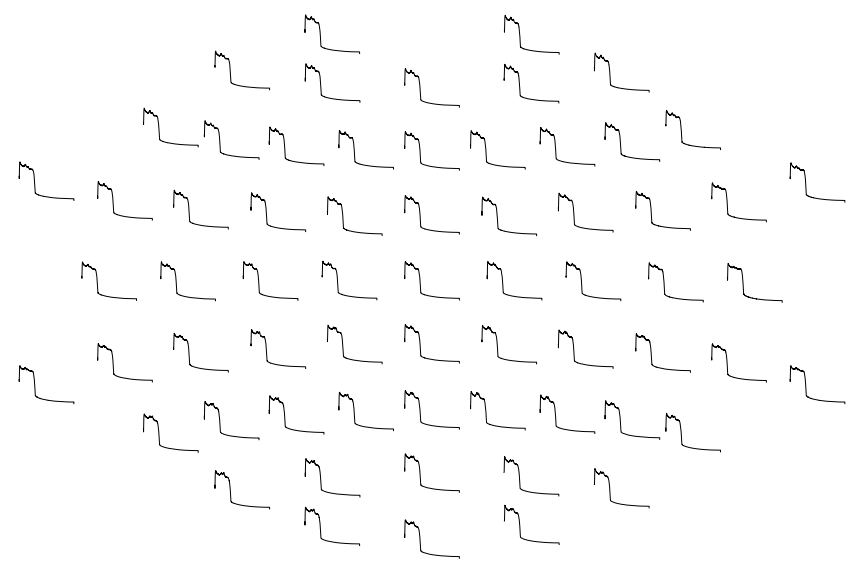

In [105]:
if data_type == 'eeg':
    raw.plot_psd_topo(fig_facecolor='w', axis_facecolor='w', color='k');

Finally, this one works for both EEG and ECoG. Here we are looking at the power spectral density plot again, but taking the average across trials and showing +/- 1 standard deviation from the mean across channels. 

<IPython.core.display.Javascript object>


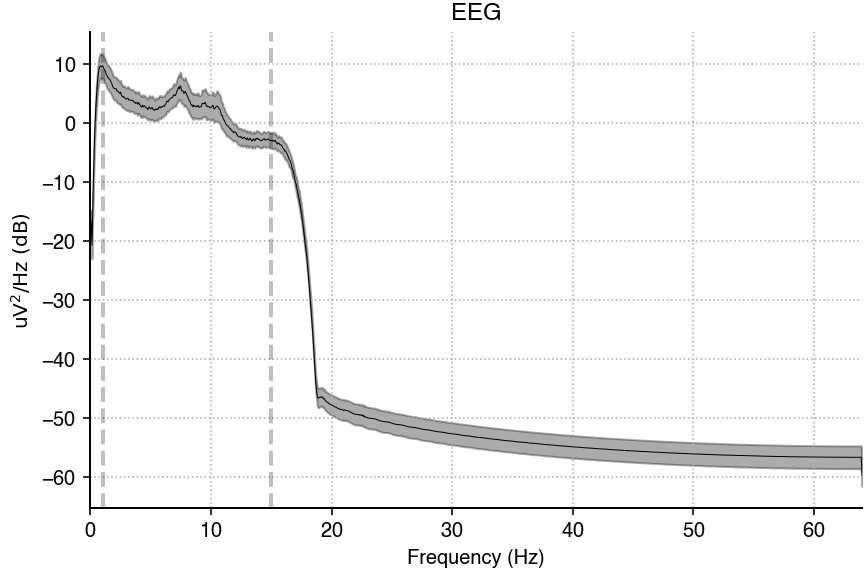

Effective window size : 16.000 (s)


In [106]:
raw.plot_psd(area_mode='std', average=True);

Finally, we can plot these same figures using a narrower frequency range, and looking at a smaller set of channels using `picks`. For `plot_psd` and other functions, `picks` is a list of integer indices corresponding to your channels of interest. You can choose these by their number, or you can use the convenient `mne.pick_channels` function to choose them by name. For example, in EEG, we often see strong responses to auditory stimuli at the top of the head, so here we will restrict our EEG channels to a few at the top of the head at the midline. For ECoG, we are more likely to see responses to auditory stimuli in temporal lobe electrodes (potentially RPPST, RPST, RMST, RAST), so we'll try those.

<IPython.core.display.Javascript object>


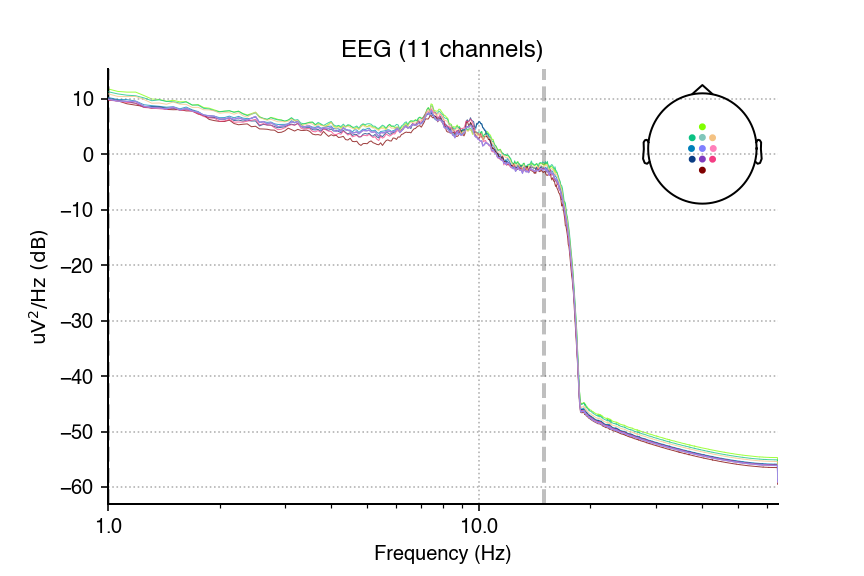

Effective window size : 16.000 (s)


<ipython-input-134-60e2431de342>:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  raw.plot_psd(picks = picks, fmin=1, fmax=100, xscale='log');


In [134]:
if data_type == 'eeg':
    picks = mne.pick_channels(raw.ch_names, include=['Pz','CPz','Cz','FCz','Fz','C1','C2','FC1','FC2','CP1','CP2'])
elif data_type == 'ecog':
    picks = mne.pick_channels(raw.ch_names, include=['RPPST9','RPPST10','RPPST11'])

raw.plot_psd(picks = picks, fmin=1, fmax=100, xscale='log');

## Plotting responses to events

Ok, so this is all well and good. We can plot our raw data, the power spectrum, and the locations of the sensors. But what if we care about responses to the stimuli we described above? What if we want to look at responses to specific sentences, or the average response across all sentences, or something else? How can we determine which EEG sensors or ECoG electrodes respond to the speech stimuli?

Enter.... *Epoching!*  MNE-python gives you a very convenient way of rearranging your data according to events of interest. These can actually even be found automatically from a stimulus channel, if you have one (using [`mne.find_events`](https://mne.tools/stable/generated/mne.find_events.html)), which we won't use here because we already have the timings from another procedure. You can also find other types of epochs, like those based on EMG or [eye movements (EOG)](https://mne.tools/stable/generated/mne.preprocessing.find_eog_events.html). 

Here, we will load our event files (ending with `_eve.txt`). These contain information about the start sample, stop sample, and event ID for each stimulus. Each row in the file is one stimulus. The timings are in samples rather than in seconds, so if you are creating these on your own, pay attention to your sampling rate (in `raw.info['sfreq']`).

In [137]:
# Load some events. The format of these is start sample, end sample, and event ID.
events = mne.read_events(event_files[data_type])
print(events)

num_events = len(events)
unique_stimuli = np.unique(np.array(events)[:,2])
num_unique = len(unique_stimuli)
print('There are %d total events, corresponding to %d unique stimuli'%(num_events, num_unique))

[[  1633   1893    105]
 [  1903   2130     43]
 [  2141   2449    153]
 ...
 [513113 513442    138]
 [513452 513707     59]
 [513716 514006    106]]
There are 595 total events, corresponding to 380 unique stimuli


## Epochs

Great. So now that we have the events, we will "epoch" our data, which basically uses these timings to split up our data into trials of a given length. We will also set some parameters for data rejection to get rid of noisy trials. 

In [147]:
# Set some rejection criteria. This will be based on the peak-to-peak
# amplitude of your data.

if data_type=='eeg':
    reject = {'eeg': 60e-6} # Higher than peak to peak amplitude of 60 µV will be rejected
    scalings = None
    units = None
elif data_type=='ecog':
    reject = {'ecog': 10} # Higher than Z-score of 10 will be rejected
    scalings = {'ecog': 1} # Don't rescale these as if they should be in µV
    units = {'ecog': 'Z-score'}
    

In [152]:
tmin = -0.2
tmax = 1.0
epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, baseline=(None, 0), reject=reject, verbose=True)

595 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


So what's in this epochs data structure? If we look at it, we can see that we have an entry for each event ID, and we can see how many times that stimulus was played. You can also see whether baseline correction was done and for what time period, and whether any data was rejected.

In [155]:
epochs

<Epochs  |   511 events (all good), -0.203125 - 1 sec, baseline [None, 0], ~169 kB, data not loaded,
 '1': 1
 '10': 11
 '100': 0
 '101': 1
 '102': 1
 '103': 2
 '104': 2
 '105': 1
 '106': 6
 '107': 1
 '108': 2
 '109': 1
 '11': 9
 '110': 2
 '111': 2
 '112': 1
 '113': 1
 '114': 1
 '115': 1
 '116': 1
 '117': 2
 '118': 1
 '119': 1
 '12': 2
 '120': 1
 '121': 1
 '122': 1
 '123': 1
 '124': 1
 '125': 9
 '126': 1
 '127': 0
 '128': 1
 '129': 1
 '13': 1
 '130': 1
 '131': 2
 '132': 1
 '133': 1
 '134': 1
 '135': 1
 '136': 1
 '137': 1
 '138': 2
 '139': 1
 '14': 1
 '140': 2
 '141': 1
 '142': 1
 '143': 2
 '144': 1
 '145': 2
 '146': 1
 '147': 2
 '148': 2
 '149': 2
 '15': 0
 '150': 1
 '151': 1
 '152': 1
 '153': 1
 '154': 0
 '155': 2
 '156': 1
 '157': 1
 '158': 1
 '159': 1
 '16': 2
 '160': 1
 '161': 1
 '162': 2
 '163': 3
 '164': 1
 '165': 0
 '166': 1
 '167': 6
 '168': 1
 '169': 1
 '17': 0
 '170': 1
 '171': 1
 '172': 1
 '173': 1
 '174': 1
 '175': 1
 '176': 1
 '177': 1
 '178': 2
 '179': 0
 '18': 0
 '180': 1

Now, you could decide at this point that you just want to work with the data directly as a numpy array. Luckily, that's super easy to do! We can just call `get_data()` on our epochs data structure, and this will output a matrix of `[events x channels x time points]`. If you do not limit the channel type, you will get all of them (including any EOG, stimulus channels, or other non-EEG/ECoG channels).

In [157]:
ep_data = epochs.get_data()
print(ep_data.shape)

Loading data for 511 events and 155 original time points ...
(511, 66, 155)


## Plotting Epoched data

Ok... so we are getting ahead of ourselves. MNE-python provides a lot of ways to plot our data so that we don't have to deal with writing functions to do this ourselves! For example, if we'd like to plot the EEG/ECoG for all of the single trials we just loaded, along with an average across all of these trials (and channels of interest), we can do that easily with `epochs.plot_image()`.

No picks and no groupby, showing the first five channels ...
Loading data for 511 events and 155 original time points ...
511 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<IPython.core.display.Javascript object>


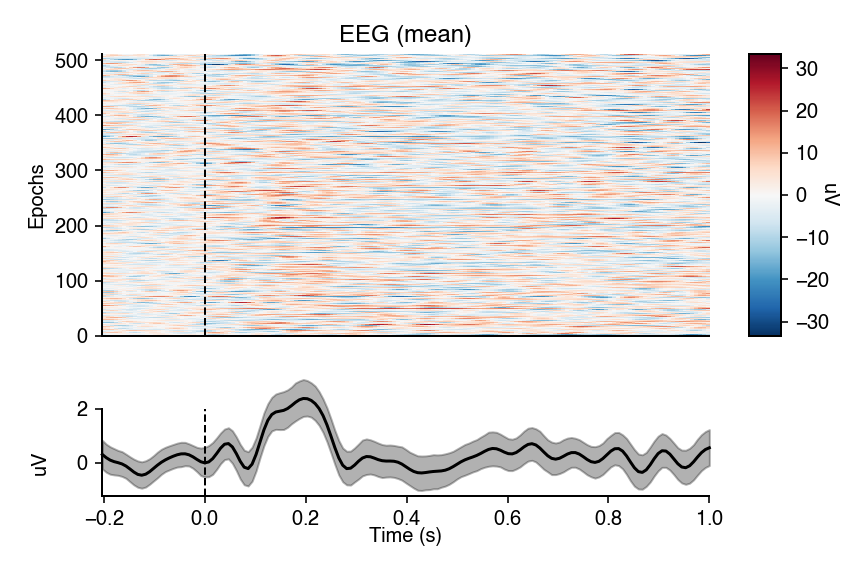

[<Figure size 432x288 with 3 Axes>]

In [158]:
epochs.plot_image(combine='mean', scalings=scalings, units=units)

As before, we can choose specific channels to look at instead of looking at all of them at once. For which method do you think this would make the most difference? Why? 

Loading data for 511 events and 155 original time points ...
511 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<IPython.core.display.Javascript object>


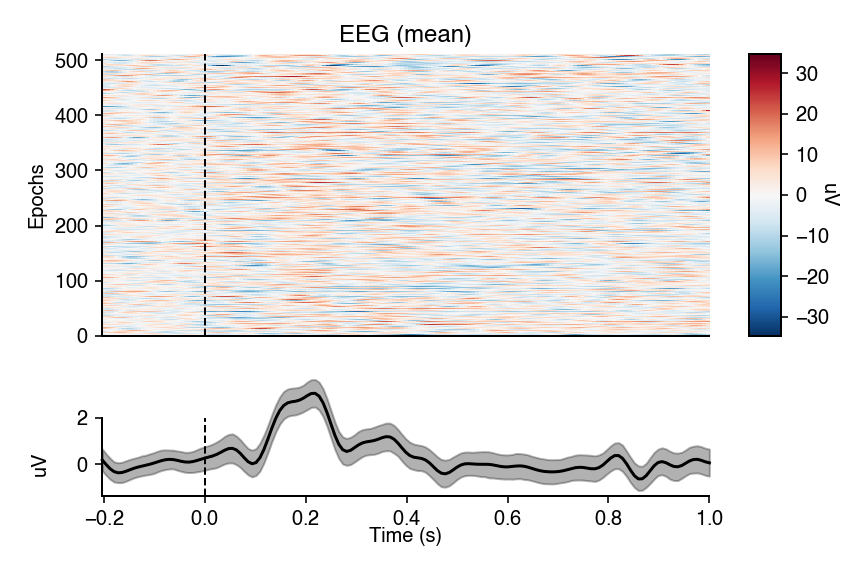

[<Figure size 432x288 with 3 Axes>]

In [160]:
if data_type == 'eeg':
    picks = mne.pick_channels(raw.ch_names, include=['Fz','FCz','Cz','CPz','Pz'])
elif data_type == 'ecog':
    picks = mne.pick_channels(raw.ch_names, include=['RPPST9','RPPST10','RPPST11'])
    
epochs.plot_image(picks = picks, combine='mean', scalings=scalings, units=units)

We can also sort the trials, if we would like. This can be very convenient if you have reaction times or some other portion of the trial where reordering would make sense. Here, we'll just pick a channel and order by the mean activity within each trial.

Loading data for 511 events and 155 original time points ...
Loading data for 511 events and 155 original time points ...


<IPython.core.display.Javascript object>


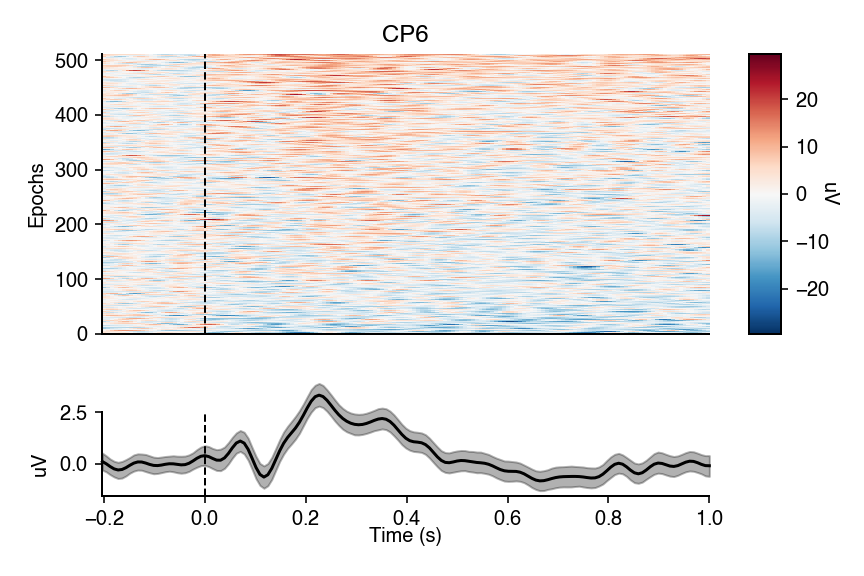

[<Figure size 432x288 with 3 Axes>]

In [167]:
if data_type == 'eeg':
    picks = mne.pick_channels(raw.ch_names, include=['CP6'])
elif data_type == 'ecog':
    picks = mne.pick_channels(raw.ch_names, include=['RPPST2'])

# Get the data as a numpy array
eps_data = epochs.get_data()

# Sort the data 
new_order = eps_data[:,picks[0],:].mean(1).argsort(0)

epochs.plot_image(picks=picks, order=new_order, scalings=scalings, units=units)

## Other ways to view epoched data

For EEG, another way to view these epochs by trial is using the scalp topography information. This allows us to quickly assess differences across the scalp in response to the stimuli. What do you notice about the responses?

Loading data for 511 events and 155 original time points ...


<IPython.core.display.Javascript object>


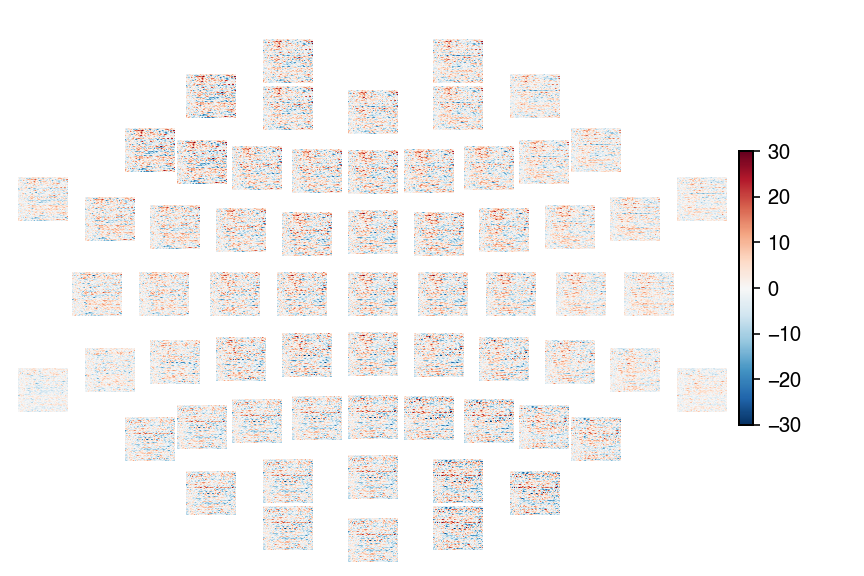

In [170]:
if data_type == 'eeg':
    epochs.plot_topo_image(vmin=-30, vmax=30, fig_facecolor='w',font_color='k');

## Comparing epochs of different trial types

So far we have just shown averages of activity across many different sentences. However, as mentioned above, the sentences come from multiple male and female talkers. So -- one quick split we could try is just to compare the responses to female vs. male talkers. This is relatively simple with the TIMIT stimuli because their file name starts with "f" or "m" to indicate this. 

In [171]:
# Make lists of the event ID numbers corresponding to "f" and "m" sentences
f_evs = []
m_evs = []
for k in event_id.keys():
    if k[0] == 'f':
        f_evs.append(event_id[k])
    elif k[0] == 'm':
        m_evs.append(event_id[k])

print(unique_stimuli)
f_evs_new = [v for v in f_evs if v in unique_stimuli]
m_evs_new = [v for v in m_evs if v in unique_stimuli]

# Epoch the data separately for "f" and "m" epochs
f_epochs = mne.Epochs(raw, events, event_id=f_evs_new, tmin=tmin, tmax=tmax, reject=reject)
m_epochs = mne.Epochs(raw, events, event_id=m_evs_new, tmin=tmin, tmax=tmax, reject=reject)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

Now we can plot the epochs just as we did above.

No picks and no groupby, showing the first five channels ...
Loading data for 174 events and 155 original time points ...
174 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<IPython.core.display.Javascript object>


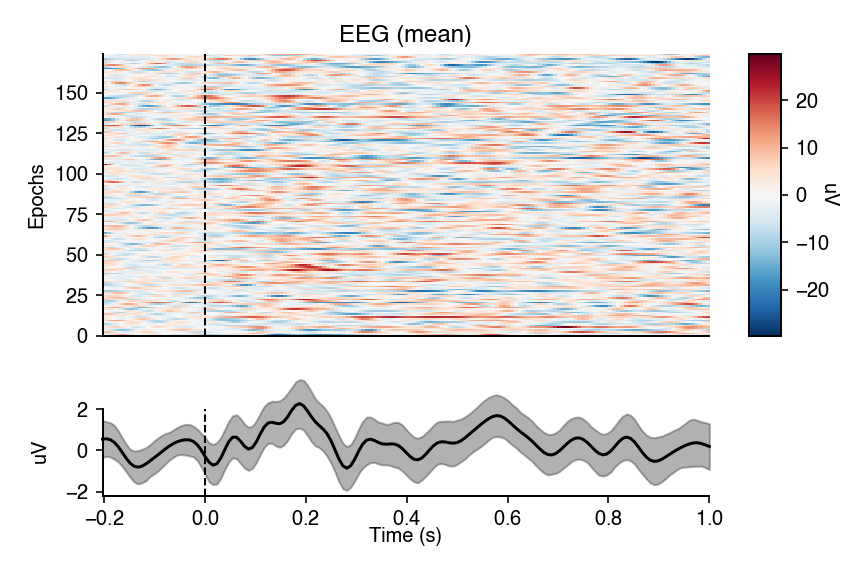

No picks and no groupby, showing the first five channels ...
Loading data for 399 events and 155 original time points ...
    Rejecting  epoch based on EEG : ['O2', 'PO4', 'PO8']
    Rejecting  epoch based on EEG : ['P3', 'O1', 'Oz', 'P1', 'P5', 'PO7', 'PO3', 'POz']
    Rejecting  epoch based on EEG : ['P3', 'P7', 'O1', 'Oz', 'O2', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P2']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'O2', 'Fp2', 'AF7', 'AF3', 'F5', 'PO4', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP1', 'Pz', 'P3', 'O1', 'Oz', 'O2', 'P4', 'P8', 'Cz', 'FC2', 'F4', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'P1', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'C2', 'FC4', 'F2', 'AF4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FC1', 'F4', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'F2', 'AF4']
   

    Rejecting  epoch based on EEG : ['P4', 'CP2', 'P2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP2', 'Cz', 'FC2', 'F4', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'C2', 'FC4', 'F2', 'AF4']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'AF7', 'AF3', 'F5']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'CP1', 'Cz', 'FC2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FC3', 'FCz', 'C1', 'C5', 'CP3', 'CPz', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FC1', 'O2', 'FC2', 'F4', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'C1', 'PO4', 'PO8', 'FC4', 'F2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'C3', 'CP1', 'FC2', 'F1', 'C1', 'CP3']
    Rejecting  epoch based on EEG : ['P2']
62 bad epochs dropped
337 matching events found
No b

<IPython.core.display.Javascript object>


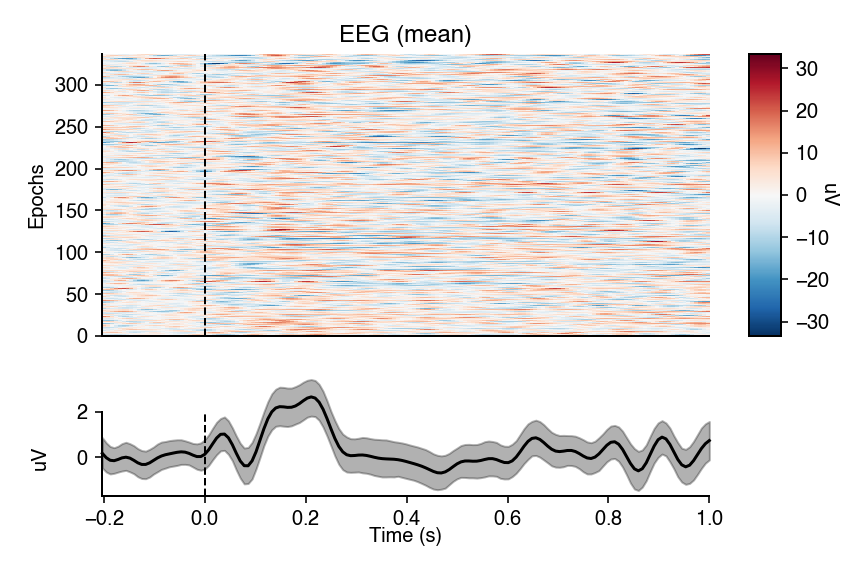

[<Figure size 432x288 with 3 Axes>]

In [173]:
f_epochs.plot_image(combine='mean', show=False, scalings=scalings, units=units)
m_epochs.plot_image(combine='mean', show=False, scalings=scalings, units=units)

Cool! So now we have a separate plot for the "f" and "m" talkers. However, it's not super convenient to compare the traces this way... we kind of want them on the same axis. MNE easily allows us to do this too! Instead of using the epochs, we can create `evoked` data structures, which are averaged epochs. You can [read more about evoked data structures here](https://mne.tools/dev/auto_tutorials/evoked/plot_10_evoked_overview.html).

## Compare evoked data

/Users/liberty/anaconda3/anaconda/envs/mne/lib/python3.6/site-packages/mne/viz/evoked.py:2150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if title is None and picks in _DATA_CH_TYPES_SPLIT:


<IPython.core.display.Javascript object>


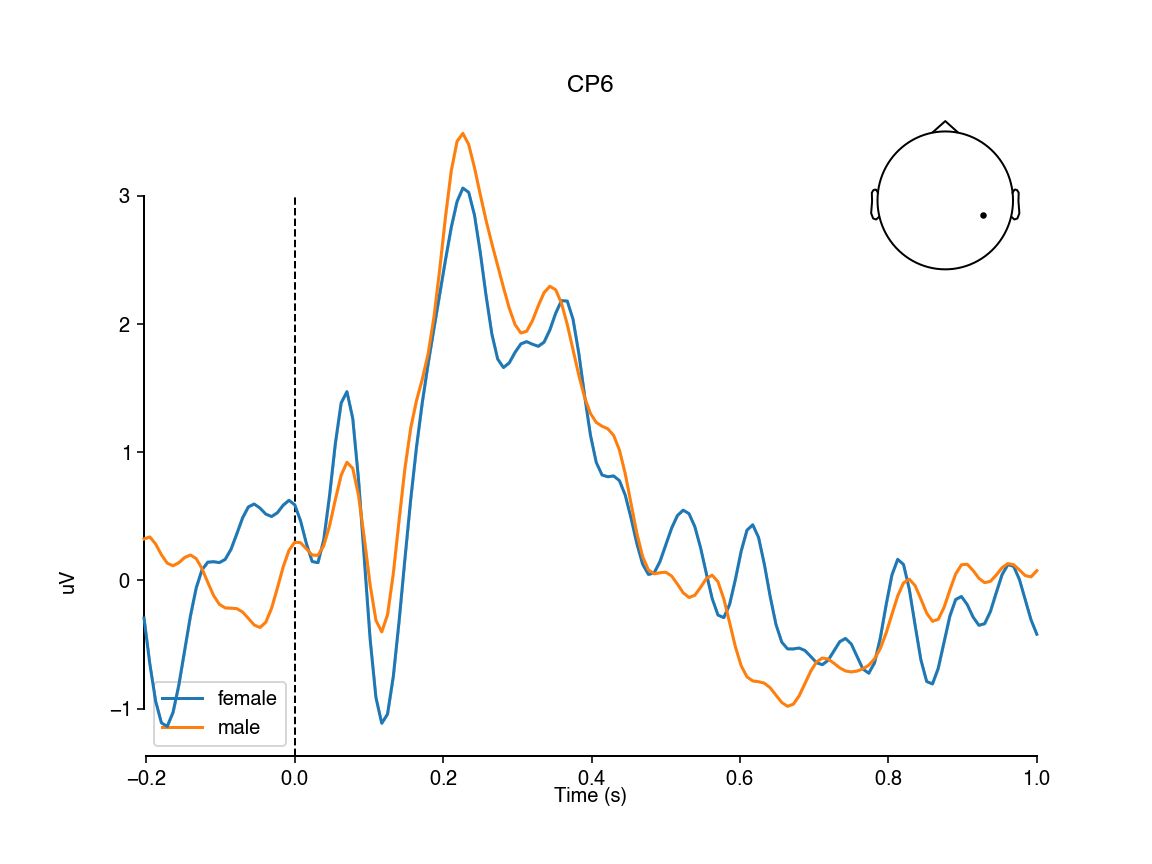

In [174]:
evokeds = {'female': f_epochs.average(), 'male': m_epochs.average()}
mne.viz.plot_compare_evokeds(evokeds, show_sensors='upper right',picks=picks);

If we actually want errorbars on this plot, we need to do this a bit differently. We can use the `iter_evoked()` method on our epochs structures to create a dictionary of conditions for which we will plot our comparisons with `plot_compare_evokeds`.

[<Evoked  |  '105' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '43' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '65' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '31' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '22' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '66' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '1' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '79' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '5' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '8' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '54' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '98' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '78' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '10' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  |  '90' (mean, N=1), [-0.20312, 1] sec, 66 ch, ~249 kB>, <Evoked  | 

/Users/liberty/anaconda3/anaconda/envs/mne/lib/python3.6/site-packages/mne/viz/evoked.py:2150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if title is None and picks in _DATA_CH_TYPES_SPLIT:


<IPython.core.display.Javascript object>


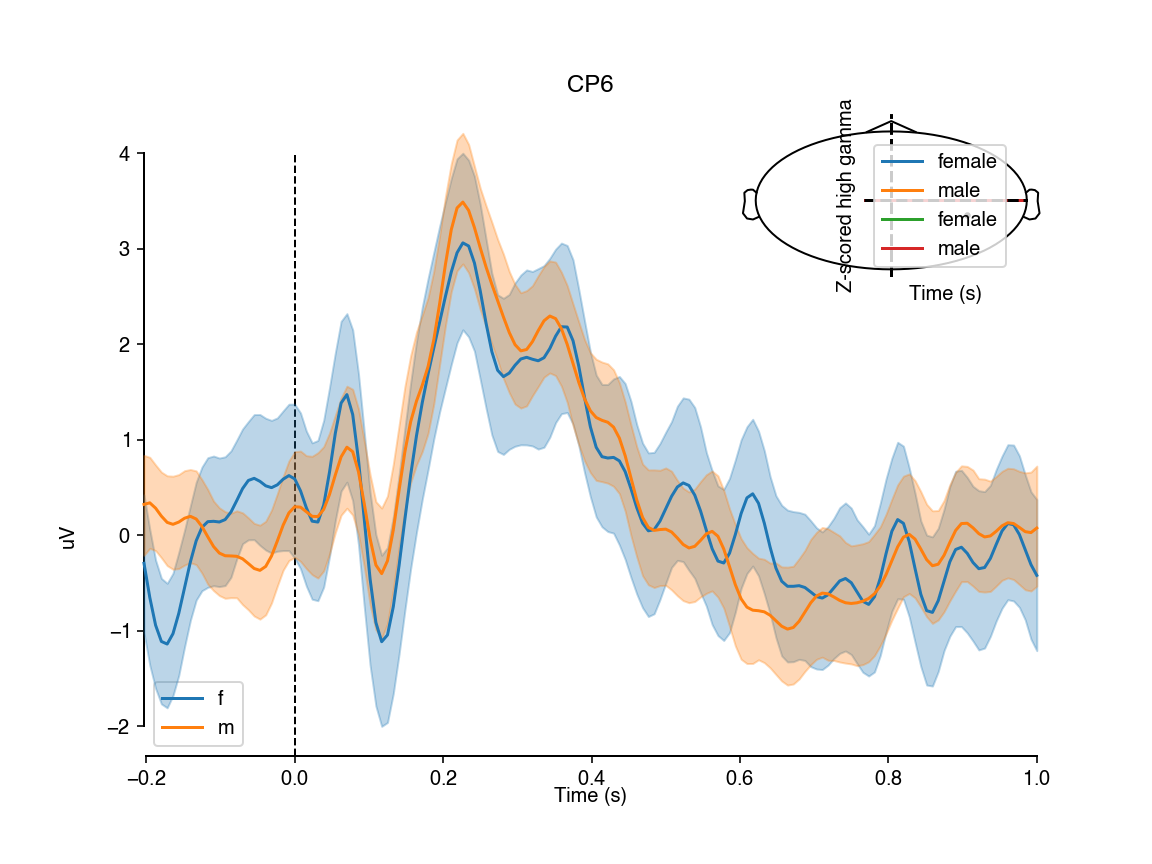

<IPython.core.display.Javascript object>


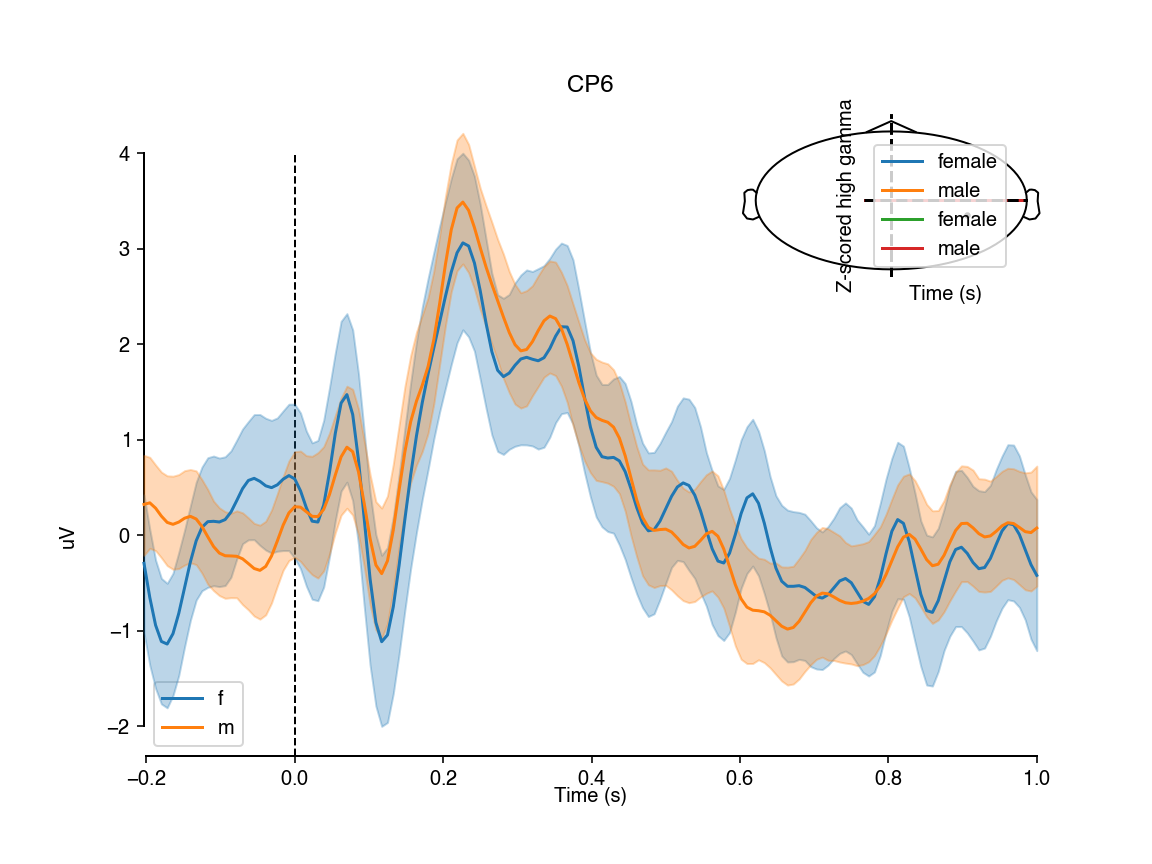

In [175]:
evokeds = {'f':list(f_epochs.iter_evoked()), 'm':list(m_epochs.iter_evoked())}
print(evokeds['f'])
mne.viz.plot_compare_evokeds(evokeds, picks=picks)


## Plotting scalp topography

For EEG, another common plot you may see is a topographic map showing activity (or other data like p-values, or differences between conditions). In this example, we'll show the activity at -0.2, 0, 0.1, 0.2, 0.3, and 1 second. You can also of course choose just one time to look at.

<IPython.core.display.Javascript object>


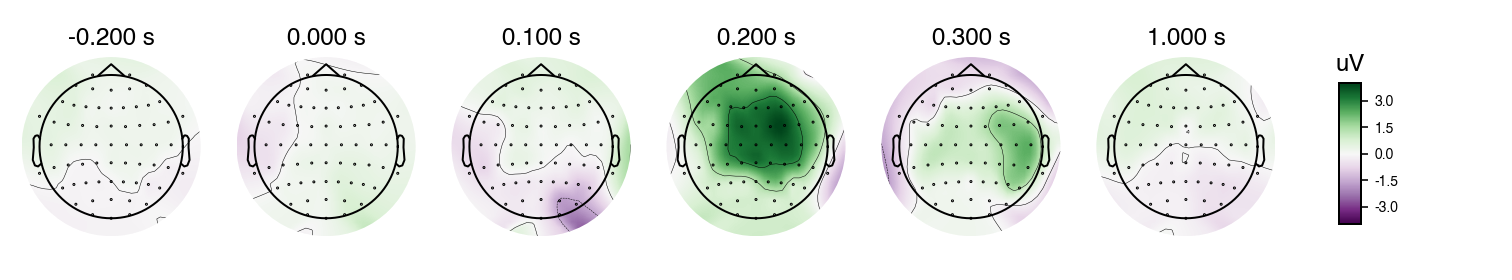

In [199]:
if data_type == 'eeg':
    times=[tmin, 0, 0.1, 0.2, 0.3, tmax]
    epochs.average().plot_topomap(times, ch_type='eeg', cmap='PRGn', res=32,
                    outlines='skirt', time_unit='s');

We can also plot arbitrary data using `mne.viz.plot_topomap`, and passing in a vector of data matching the number of EEG channels, and `raw.info` to give specifics on those channel locations.

<IPython.core.display.Javascript object>


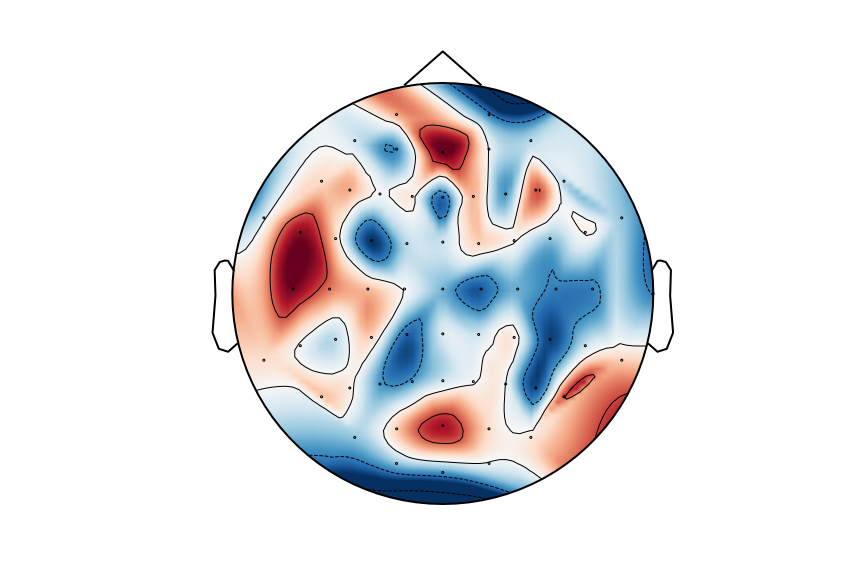

In [207]:
if data_type == 'eeg':
    chans = mne.pick_types(raw.info, eeg=True)
    data = np.random.randn(len(chans),)
    plt.figure()
    mne.viz.plot_topomap(data, raw.info, show=True)


We can even animate these topo maps! This won't work well in jupyterhub, but feel free to try on your own!

<IPython.core.display.Javascript object>


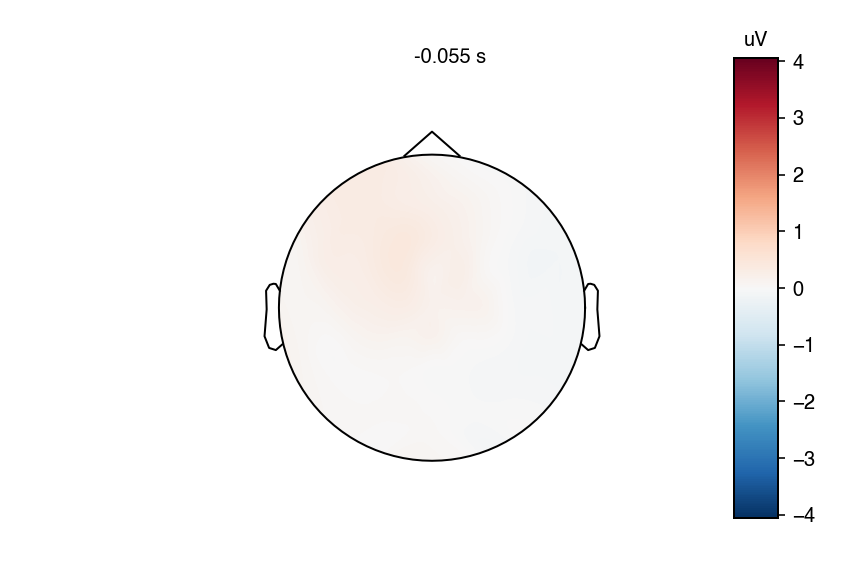

In [209]:
if data_type == 'eeg':
    fig,anim=epochs.average().animate_topomap(blit=False, times=np.linspace(tmin, tmax, 100))

## A few more fancy EEG plots

If we want to get especially fancy, we can also use `plot_joint` with our evoked data (or averaged epoched data, as shown below). This allows us to combine the ERPs for individual channels with topographic maps at time points that we specify. Pretty awesome!

<IPython.core.display.Javascript object>


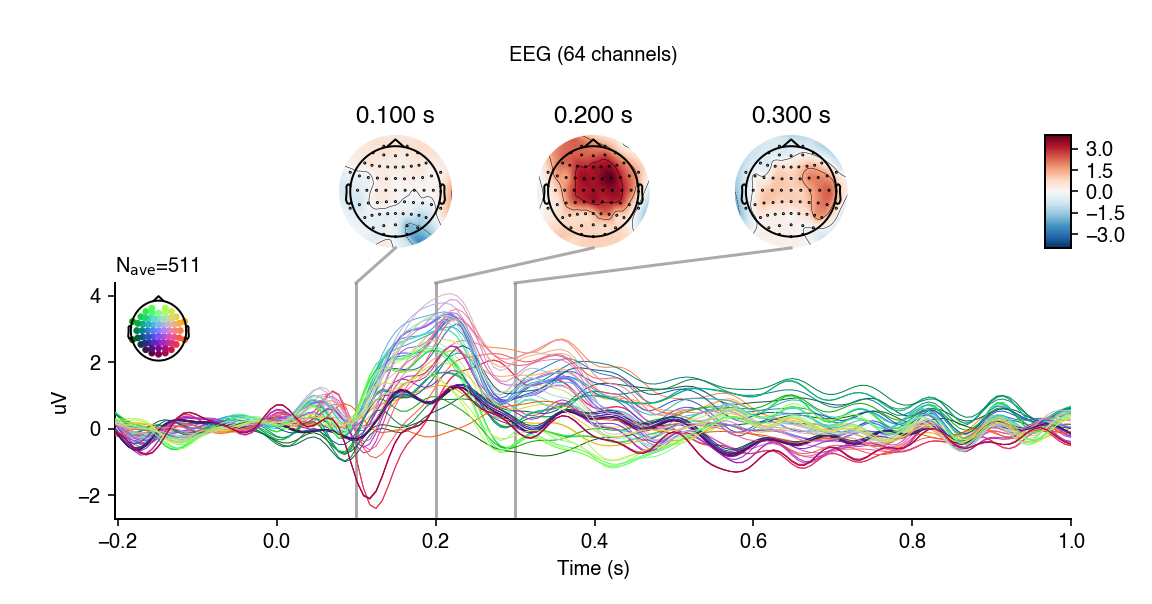

In [210]:
if data_type == 'eeg':
    epochs.average().plot_joint(picks='eeg', times=[0.1, 0.2, 0.3])

# What if I need more control? - matplotlib alternatives

If you feel you need more specific control over your plots, it's easy to get the data into a usable format for plotting with matplotlib. You can export both the raw and epoched data using the `get_data()` function, which will allow you to save your data as a numpy array `[ntrials x nchannels x ntimepoints]`.

Then, you can do whatever you want with the data! Throw it into matplotlib, use seaborn, or whatever your heart desires!

In [218]:
if data_type == 'eeg':
    picks = mne.pick_channels(raw.ch_names, include=['Fz','FCz','Cz','CPz','Pz'])
elif data_type == 'ecog':
    picks = mne.pick_channels(raw.ch_names, include=['RPPST9','RPPST10','RPPST11'])
    
f_data = f_epochs.get_data(picks=picks)
m_data = m_epochs.get_data(picks=picks)
times = f_epochs.times

print(f_data.shape)

Loading data for 174 events and 155 original time points ...
Loading data for 337 events and 155 original time points ...
(174, 5, 155)


## Plot evoked data with errorbars 

We can recreate some similar plots to those in MNE-python with some of the matplotlib functions. Here we'll create something similar to what was plotted in `plot_compare_evokeds`.

In [219]:
def plot_errorbar(x, ydata, label=None, axlines=True, alpha=0.5, **kwargs):
    '''
    Plot the mean +/- standard error of ydata.
    Inputs:
        x : vector of x values
        ydata : matrix of your data (this will be averaged along the 0th dimension)
        label : A string containing the label for this plot
        axlines : [bool], whether to draw the horizontal and vertical axes
        alpha: opacity of the standard error area
    '''
    ymean = ydata.mean(0)
    ystderr = ydata.std(0)/np.sqrt(ydata.shape[0])
    plt.plot(x, ydata.mean(0), label=label, **kwargs)
    plt.fill_between(x, ymean+ystderr, ymean-ystderr, alpha=alpha, **kwargs)
    if axlines:
        plt.axvline(0, color='k', linestyle='--')
        plt.axhline(0, color='k', linestyle='--')
    plt.gca().set_xlim([x.min(), x.max()])

<IPython.core.display.Javascript object>


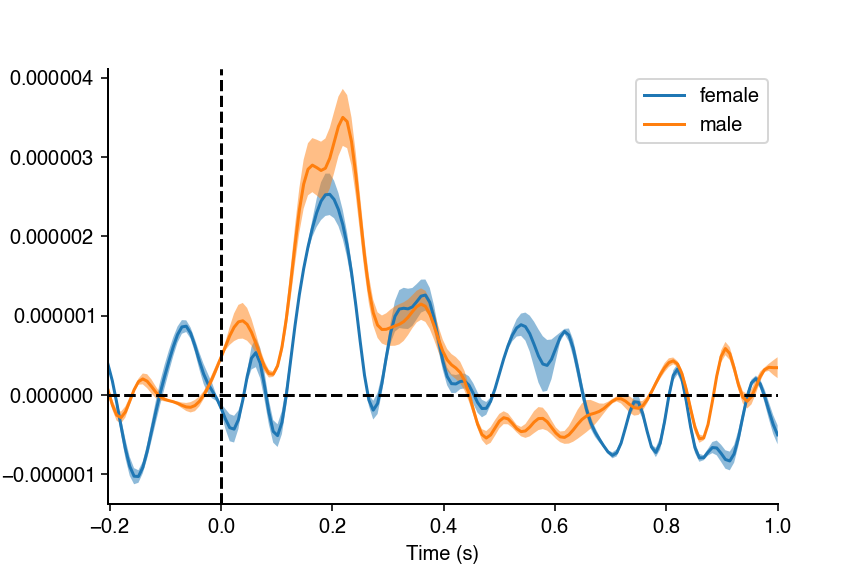

In [220]:
plt.figure()
plot_errorbar(times, f_data.mean(0), label='female')
plot_errorbar(times, m_data.mean(0), label='male')
plt.xlabel('Time (s)')
plt.ylabel('Z-scored high gamma')
plt.legend()

## ECoG Exercise:

1. If you wanted to look at each ECoG electrode individually to find which ones have responses to the speech data, how would you do this?
2. Can you plot the comparison between "f" and "m" trials for each electrode as a subplot (try using `plt.subplot()` from `matplotlib`)

In [221]:
# Get the data for f trials

# Get the data for m trials

# Loop through each channel, and create a set of subplots for each

# Hooray, the End!

You did it! Go forth and use MNE-python in your own projects, or even contribute to the code! 🧠